C:\Users\ChenJ\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\ChenJ\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/50 Loss: 0.3591260015964508
Epoch 2/50 Loss: 0.2616664469242096
Epoch 3/50 Loss: 0.3630441427230835
Epoch 4/50 Loss: 0.23903650045394897
Epoch 5/50 Loss: 0.17954052984714508
Epoch 6/50 Loss: 0.09439664334058762
Epoch 7/50 Loss: 0.11730866134166718
Epoch 8/50 Loss: 0.08825740963220596
Epoch 9/50 Loss: 0.10176879167556763
Epoch 10/50 Loss: 0.0982317104935646
Epoch 11/50 Loss: 0.09200991690158844
Epoch 12/50 Loss: 0.08608292043209076
Epoch 13/50 Loss: 0.07049652189016342
Epoch 14/50 Loss: 0.08975620567798615
Epoch 15/50 Loss: 0.07911860942840576
Epoch 16/50 Loss: 0.06034332141280174
Epoch 17/50 Loss: 0.05337345600128174
Epoch 18/50 Loss: 0.04878203198313713
Epoch 19/50 Loss: 0.04225723817944527
Epoch 20/50 Loss: 0.05688212439417839
Epoch 21/50 Loss: 0.04801015928387642
Epoch 22/50 Loss: 0.06489314138889313
Epoch 23/50 Loss: 0.03892158716917038
Epoch 24/50 Loss: 0.04937880486249924
Epoch 25/50 Loss: 0.03612518683075905
Epoch 26/50 Loss: 0.04437438026070595
Epoch 27/50 Loss: 0.05512

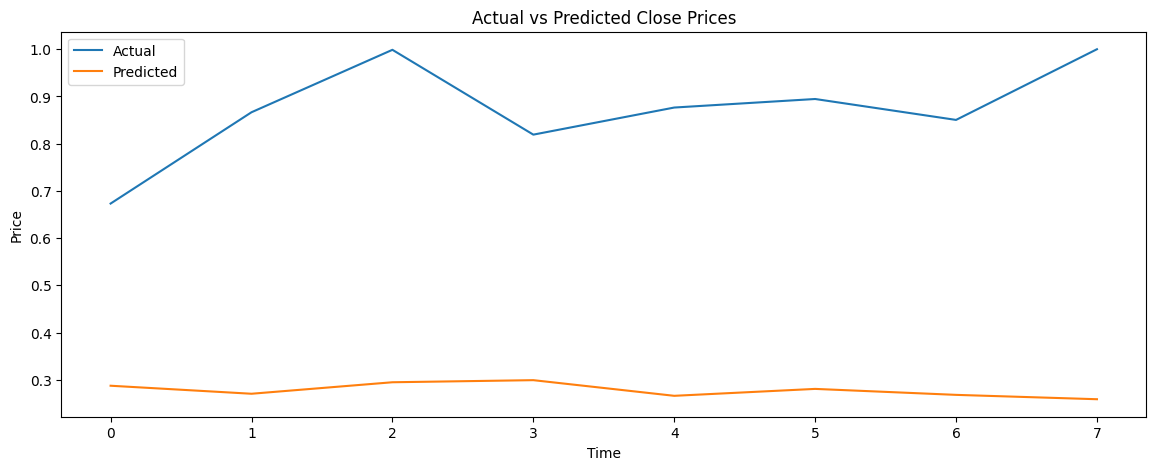

In [1]:
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
# Load the dataset
df = pd.read_csv('data/AAPL.csv.csv')

# Calculate moving average as an additional feature (example with window of 10 days)
df['ma_10'] = df['close'].rolling(window=10).mean()

# Drop rows with NaN values resulting from the moving average calculation
df.dropna(inplace=True)

# Normalize the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['open', 'high', 'low', 'close', 'vol', 'ma_10']] = scaler.fit_transform(df[['open', 'high', 'low', 'close', 'vol', 'ma_10']])

# Convert the DataFrame to a PyTorch tensor
import torch

data = torch.tensor(df[['open', 'high', 'low', 'close', 'vol', 'ma_10']].values, dtype=torch.float32)

# Create sequences (10 days lookback)
lookback = 10
X, y = [], []

for i in range(lookback, len(data)):
    X.append(data[i-lookback:i])
    y.append(data[i, 3])  # Assuming 'close' is at index 3

X = torch.stack(X)
y = torch.stack(y)

import torch.nn as nn

class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_layers, num_heads, ffn_hidden, dropout):
        super(TransformerModel, self).__init__()

        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=num_heads,
            dim_feedforward=ffn_hidden,
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(input_dim, 1)

    def forward(self, src):
        out = self.transformer_encoder(src)
        out = self.fc(out[:, -1, :])  # Take output of the last time step
        return out
# Split the dataset into training and testing sets
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Define the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerModel(input_dim=X.shape[-1], num_layers=2, num_heads=2, ffn_hidden=128, dropout=0.2).to(device)

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train.to(device))
    loss = loss_fn(output, y_train.to(device))
    loss.backward()
    optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs} Loss: {loss.item()}')

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model.eval()
with torch.no_grad():
    predictions = model(X_test.to(device)).cpu()
    y_true = y_test.numpy()
    y_pred = predictions.numpy()

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f'MAE: {mae}, RMSE: {rmse}, R^2: {r2}')

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

C:\Users\ChenJ\AppData\Local\Temp\ipykernel_12972\3169079743.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
C:\Users\ChenJ\AppData\Local\Temp\ipykernel_12972\3169079743.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
C:\Users\ChenJ\AppData\Local\Temp\ipykernel_12972\3169079743.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to

Epoch 1/50 Loss: 0.0007621081895194948
Epoch 2/50 Loss: 0.0074732182547450066
Epoch 3/50 Loss: 0.002226815093308687
Epoch 4/50 Loss: 0.0023319299798458815
Epoch 5/50 Loss: 0.0017840308137238026
Epoch 6/50 Loss: 0.008002225309610367
Epoch 7/50 Loss: 0.0035451992880553007
Epoch 8/50 Loss: 0.005638766568154097
Epoch 9/50 Loss: 0.0016951900906860828
Epoch 10/50 Loss: 0.0015576488804072142
Epoch 11/50 Loss: 0.0014617624692618847
Epoch 12/50 Loss: 0.013827851042151451
Epoch 13/50 Loss: 0.0025266334414482117
Epoch 14/50 Loss: 0.1307879090309143
Epoch 15/50 Loss: 0.001365644857287407
Epoch 16/50 Loss: 0.0021782666444778442
Epoch 17/50 Loss: 2.658712401171215e-05
Epoch 18/50 Loss: 0.000722358119674027
Epoch 19/50 Loss: 0.003311898559331894
Epoch 20/50 Loss: 2.025908906944096e-05
Epoch 21/50 Loss: 0.016512461006641388
Epoch 22/50 Loss: 0.0006201437208801508
Epoch 23/50 Loss: 0.1678575873374939
Epoch 24/50 Loss: 0.00013640319230034947
Epoch 25/50 Loss: 0.0002568810887169093
Epoch 26/50 Loss: 0.00

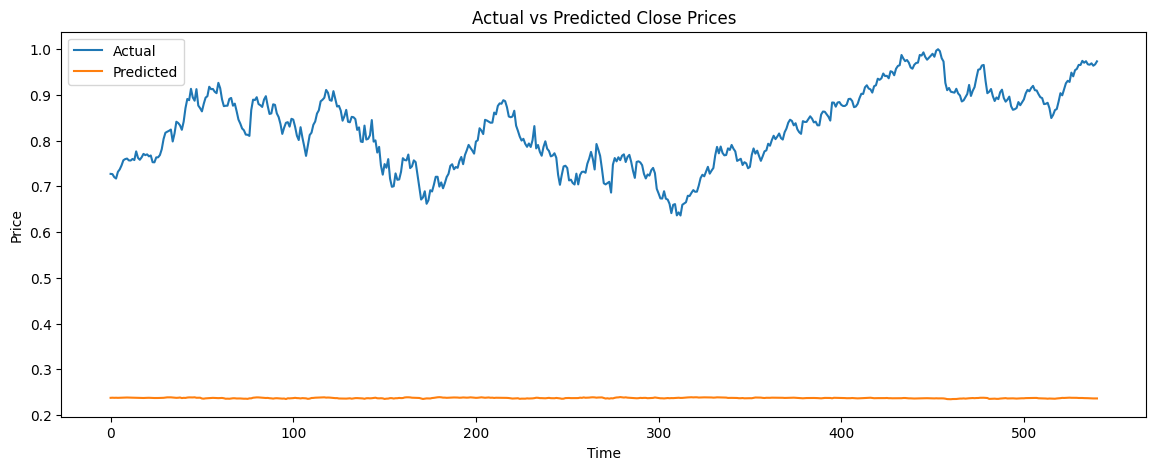

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load the dataset
df = pd.read_csv('data/AAPL.csv')

# Calculate moving average as an additional feature (example with window of 10 days)
df['ma_10'] = df['close'].rolling(window=10).mean()

# Drop rows with NaN values resulting from the moving average calculation
df.dropna(inplace=True)

# Normalize the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['open', 'high', 'low', 'close', 'vol', 'ma_10']] = scaler.fit_transform(df[['open', 'high', 'low', 'close', 'vol', 'ma_10']])

# Convert the DataFrame to a PyTorch tensor
import torch

data = torch.tensor(df[['open', 'high', 'low', 'close', 'vol', 'ma_10']].values, dtype=torch.float32)

# Create sequences (10 days lookback)
lookback = 10
X, y = [], []

for i in range(lookback, len(data)):
    X.append(data[i-lookback:i])
    y.append(data[i, 3])  # Assuming 'close' is at index 3

X = torch.stack(X)
y = torch.stack(y)

import torch.nn as nn

class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_layers, num_heads, ffn_hidden, dropout):
        super(TransformerModel, self).__init__()

        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=num_heads,
            dim_feedforward=ffn_hidden,
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(input_dim, 1)

    def forward(self, src):
        out = self.transformer_encoder(src)
        out = self.fc(out[:, -1, :])  # Take output of the last time step
        return out
# Split the dataset into training and testing sets
train_size = int(len(X) * 0.95)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

batch_size = 32  # Set your desired batch size

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False)

# Define the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerModel(input_dim=X.shape[-1], num_layers=2, num_heads=2, ffn_hidden=128, dropout=0.2).to(device)

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for data, targets in train_loader:
        output = model(data.to(device))
        loss = loss_fn(output, targets.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs} Loss: {loss.item()}')

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model.eval()
with torch.no_grad():
    predictions = model(X_test.to(device)).cpu()
    y_true = y_test.numpy()
    y_pred = predictions.numpy()

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f'MAE: {mae}, RMSE: {rmse}, R^2: {r2}')

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()